## Here, we will be going over the way to setup an Ingrained-STM calculation, and the different use cases

This example is for the (111) facet of Cu$_2$O

First, let's load the necessary modules

In [ ]:
import numpy as np
import os
from ingrained.structure import PartialCharge
from ingrained.optimize import CongruityBuilder
from ingrained.utilities import multistart,multistart_series,compareAngles,multistart_stm_angle
import ingrained.image_ops as iop

Next, let's load an experimental STM image

In [ ]:
# Load experimental image (monochrome; txt, sxm, png, tiff, etc.)
image_data = iop.image_open('Cu2O_image.txt')

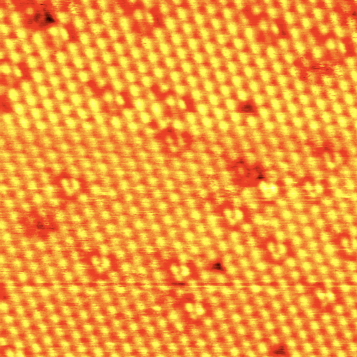

If an SXM file or properly-formatted txt file was used, then the ratio of Angstrom-to-pixel will already be defined. Otherwise, define it yourself by dividing the length of the experimental image by the number of pixels along that directions of your image

In [ ]:
image_data['Experiment Pixel Size']=.29296875

Next, we will want to crop the experimental image to be focused on the highest quality region of interest

In [ ]:
image_data['Pixels']=image_data['Pixels'][220:370,140:290]

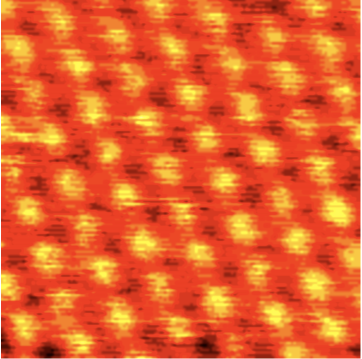

Now that we have a cropped region of interest, let's load the partial charge density we calculated for the proposed surface. The charge density needs to be aligned to the center of the cell so it doesn't cross the periodic boundary condition, so we'll use the "._shift_sites" function.

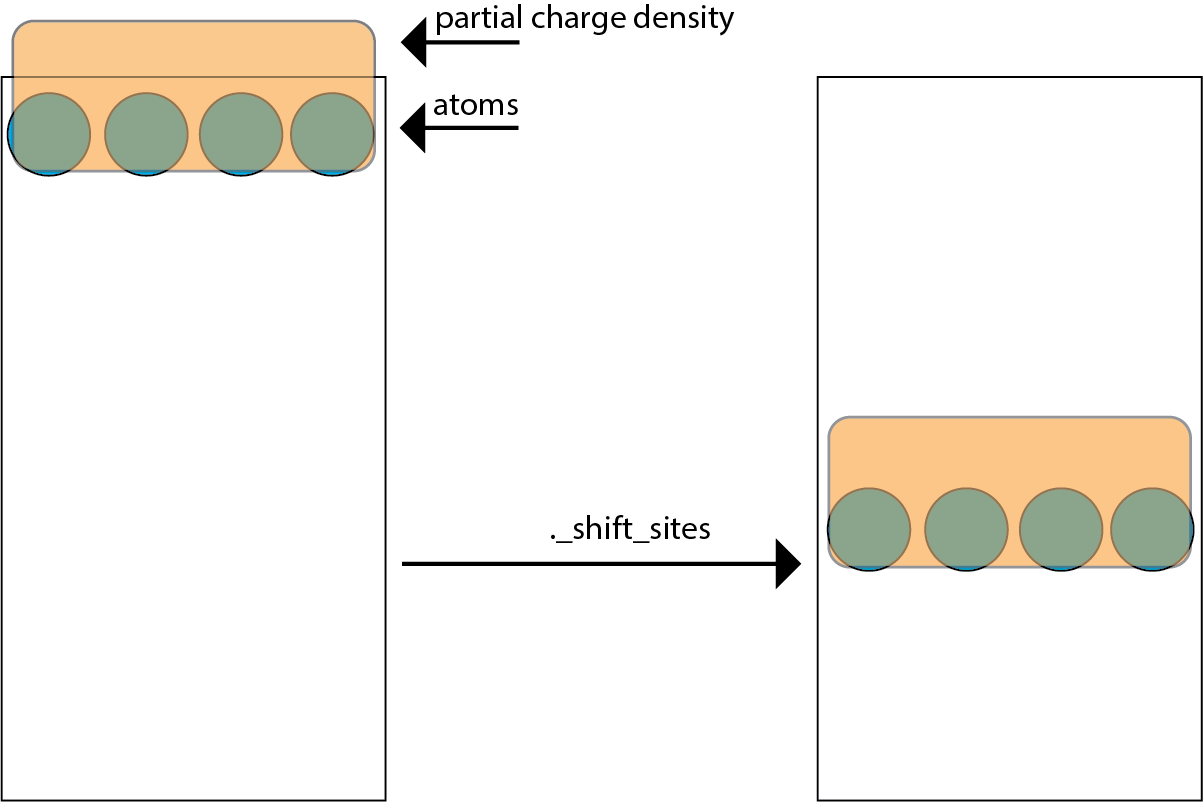

In [ ]:
sim_obj = PartialCharge('Cu2O_111_PARCHG')
# Add pixel size to simulation object so that
# it becomes a constrained parameter
sim_obj.pix_size=image_data['Experiment Pixel Size']
# Align charge density to center of cell
sim_obj._shift_sites()

If you're not sure about the angle of your unit cell relative to the experimental image, there are two automated ways to get the "best" angle for aligning your experimental and theoretical image.


1.   The "compareAngles" function
2.   The "multistart_stm_angle" function



If you want to quickly identify a good angle to perform your calculation at, then the "compareAngles" function will work well. You set an initial depth below and height above the surface, and an initial STM image will be generated.

Then, this image is matched against the experimental image, and a score is generated for that angle. Then, the image is rotated, a match re-created, and score re-generated. This is repeated a number of times based on the interval chosen by the user.

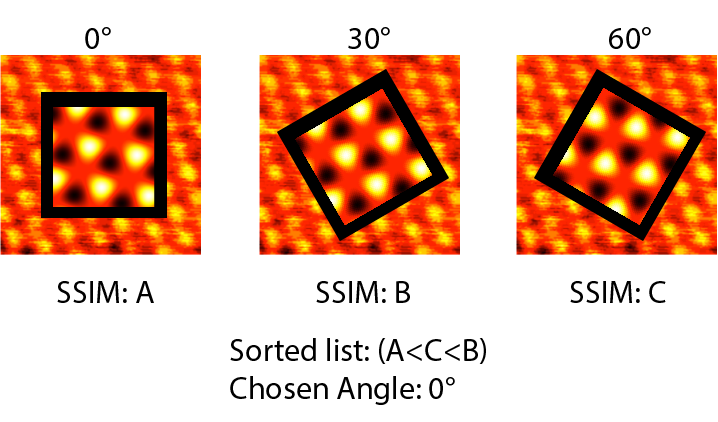

In [ ]:
# z_below, z_above, simulation_object, image_data, rotation interval
bestAngleList = compareAngles(.05,.15,sim_obj,image_data,10)
bestAngleList.sort()
angle_of_choice = bestAngleList[0][1]

Alternatively, you can fully optimize with Ingrained-STM at each angle. This provides the best results, but requires Ingrained is run a number of times before the "real" run begins. This is the method with the best results, at expense of greater computational cost.

In [ ]:
# Set up simulation parameters
# z_below, z_above, r_val, r_tol, x_shear, y_shear, x_stretch, y_stretch,
# rotation angle, pixel_size, sigma (smearing), crop_height, crop_width
sim_params = [.05,.15,.015,.01,0,0,0,0,
              110,image_data['Experiment Pixel Size'],1,100,100]

# sim_params, number of parallel runs, sim_obj, experimental image,
# indexes of parameters to fix during run, interval for sampling, maximum angle
multistart_stm_angle(sim_params,4,sim_obj,image_data['Pixels'],
                     fixed_params=[4,5,6,7],interval=30,cap=331)

Next, you will need to make a number of considerations. How many runs you want to perform, whether they should be in series or in parallel, what your intial parameters should be, what would be best on the hardware available to you.

If you want to run a number of parallel runs, use the function below

In [ ]:
# sim_params, number of runs (parallel),  sim_obj, experimental image,
# stm or gb search, indexes of parameters to fix during run

multistart(sim_params,36,sim_obj,image_data['Pixels'],
           search_mode='stm',fixed_params=[4,5,6,7])

Because Ingrained solves a local optimization problem, it is recommended to run a number of simulations. Shown below are 8 Ingrained runs with the multistart function, some of which converged on very different minima.

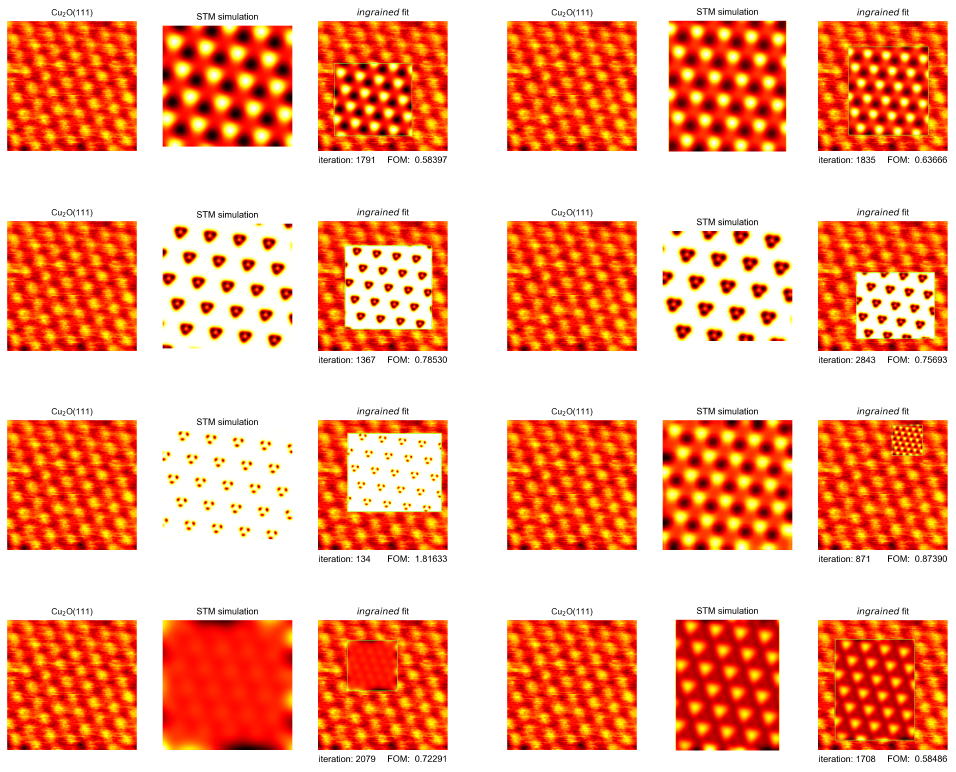

If you want a multistart approach, but only have access to a single cpu, then the series multistart approach is best

In [ ]:
# sim_params, number of runs (series),  sim_obj, experimental image,
# stm or gb search, indexes of parameters to fix during run, where to write files
multistart_series(sim_params,16,sim_obj,image_data['Pixels'],
                search_mode='stm', fixed_params=[4,5,6,7],path='')

If you only want to run a single Ingrained optimization with a single set of input parameters, use the below function

In [ ]:
congruity = CongruityBuilder(sim_obj=sim_obj, exp_img=image_data['Pixels'])
# Optimization objective, optimizer,
# sim_params, indexes of parameters to fix during run,
# search mode (stm or gb)
congruity.find_correspondence(objective='taxicab_ssim', optimizer='Powell',
                            initial_solution=sim_params,fixed_params=[4,5,6,7],
                            search_mode="stm")


After the runs are complete, you can rank your results based on their SSIM score and observe the best fits! You can plot the fits with the below code.

In [ ]:
import os
import sys
sys.path.append('../../../../')
import numpy as np
import ingrained.image_ops as iop
import matplotlib.pyplot as plt
from ingrained.structure import PartialCharge
from ingrained.optimize import CongruityBuilder
from ingrained.utilities import print_frames


image_data = iop.image_open('Cu2O_image.txt')
exp_img = image_data['Pixels'][220:370,140:290]
parchg = PartialCharge('Cu2O_111_PARCHG')
parchg._shift_sites()
parchg._shift_sites()

congruity = CongruityBuilder(sim_obj=parchg, exp_img=exp_img)
print_frames(config_file='Cu2O_111_PARCHG', exp_img=exp_img, exp_title="Cu$_{2}$O(111)",
                progress_file="progress.txt", frame_selection="best",
                search_mode="stm", cmap="hot",file_name='run_'+str(i)+'.png')

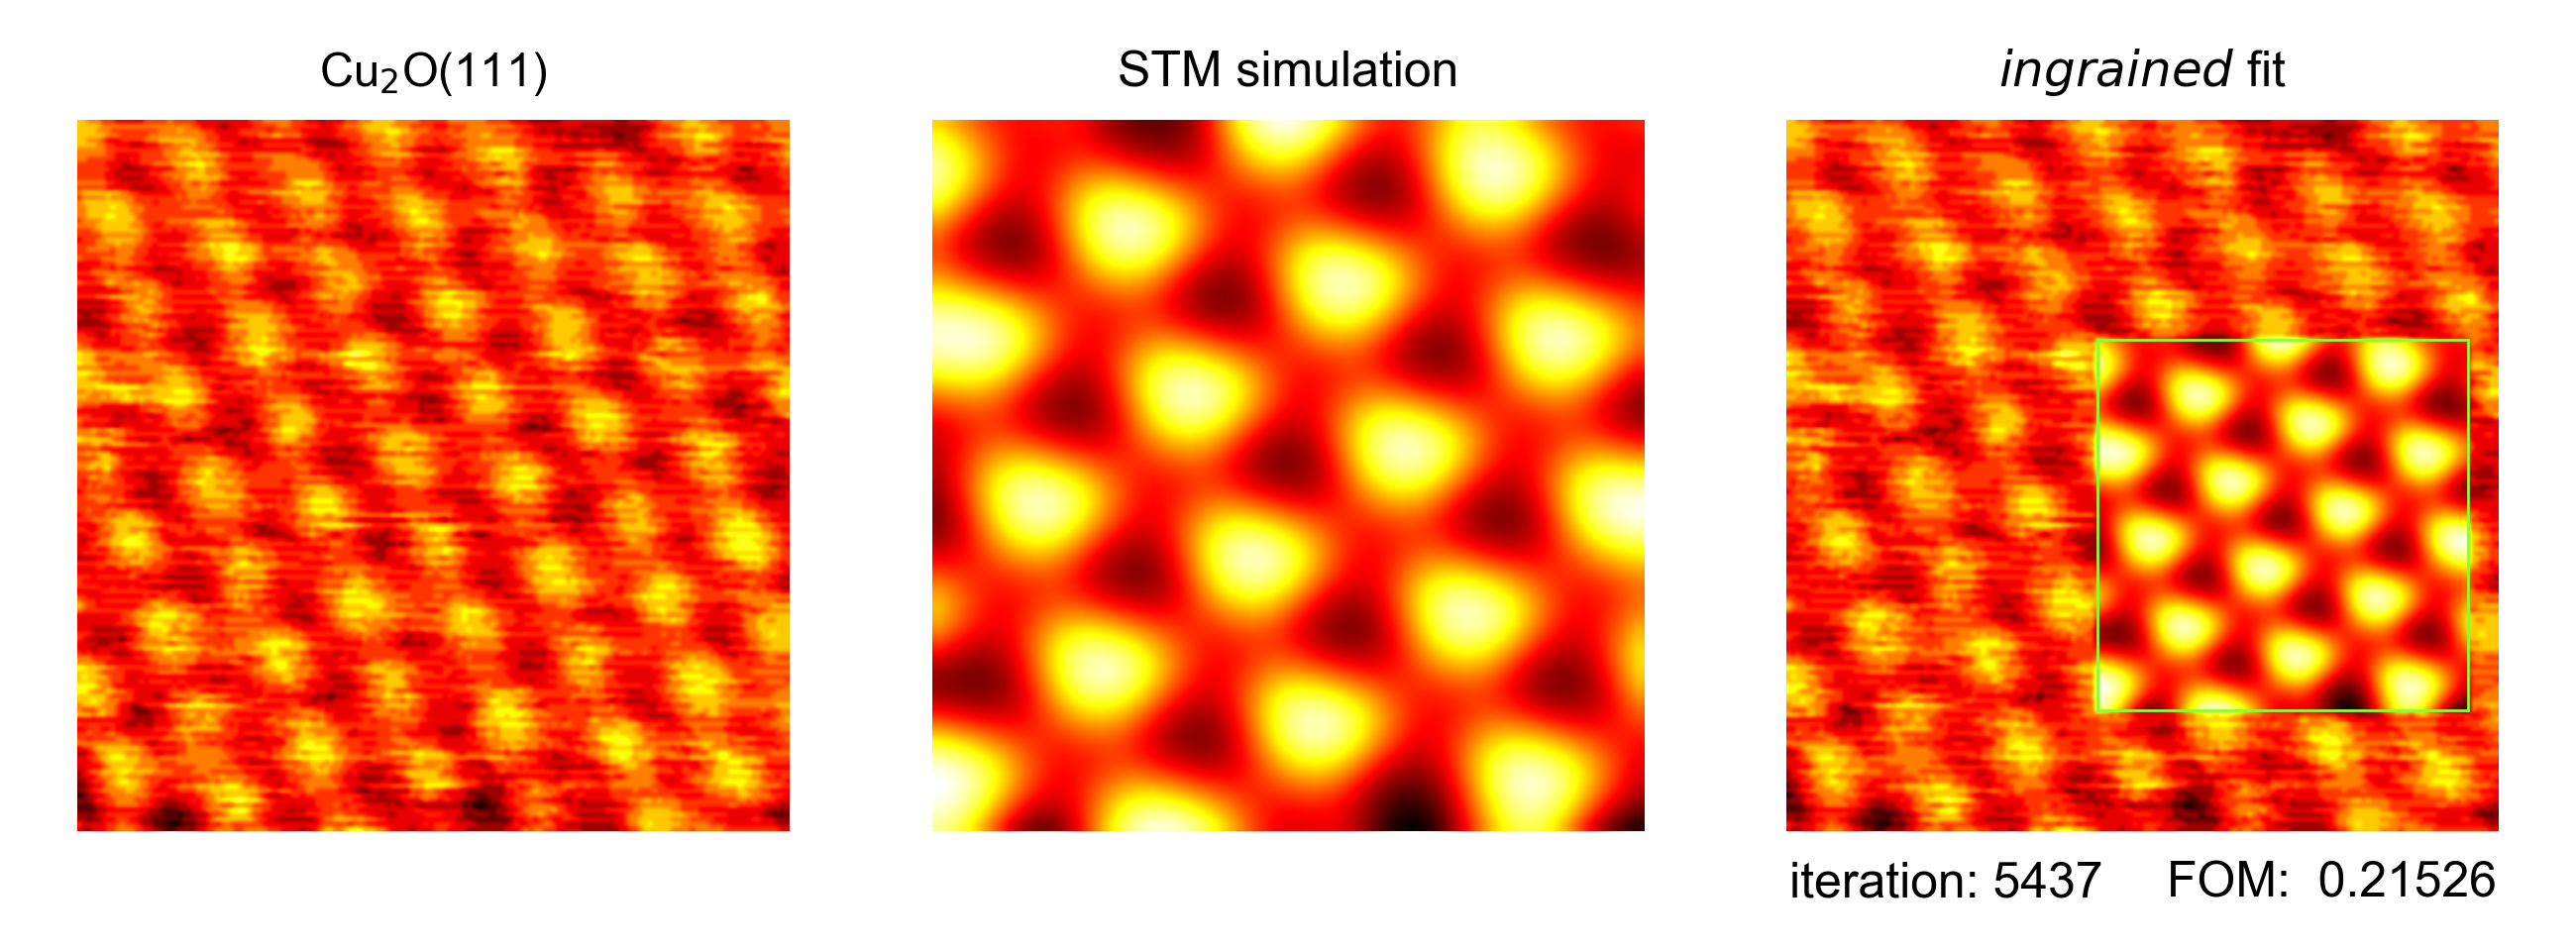

With the predicted crystal structure!

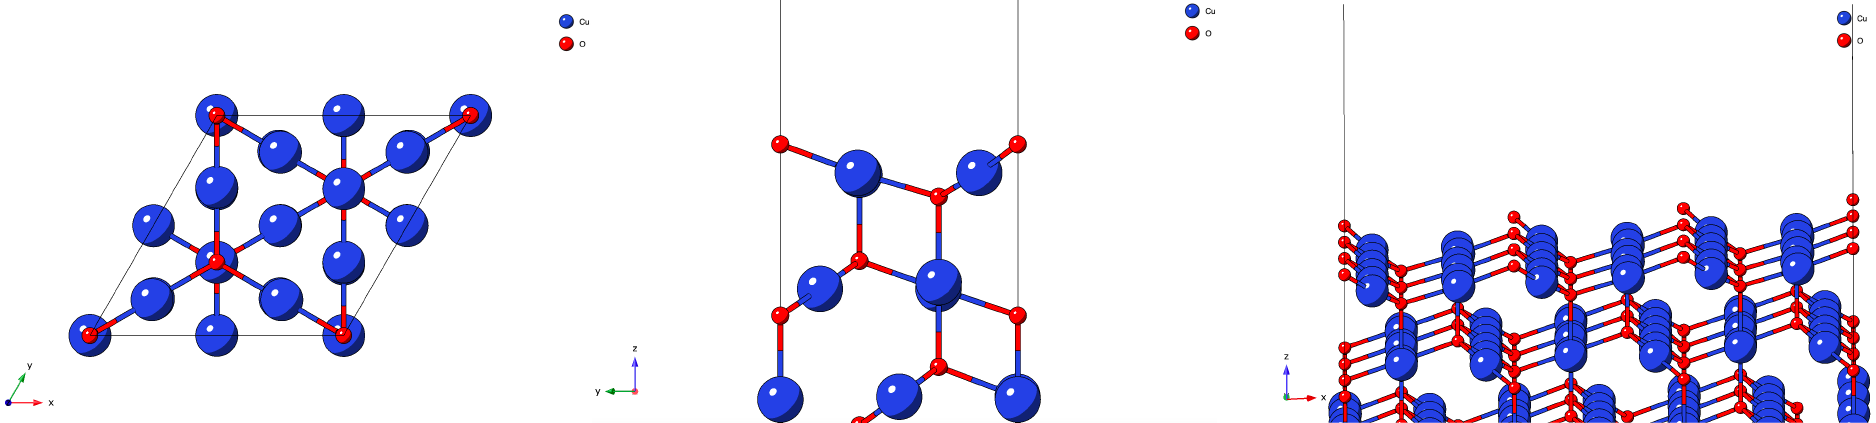